<a href="https://colab.research.google.com/github/Shahadat-360/AI/blob/main/FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

Dataset Loading From Kaggle by using API

In [ ]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F8782%2F2431805%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240817%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240817T091407Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6c030774dd864f3f28348966c8f556982cfa37f69bc8c7b00a1febca978bf22cfa18fc7a74d22831faf728da084ce2b986ff3bc477ddb00d52d1c5283775aecbad153f181a8f630585b6db65fe2795fcf606447d3e8c95d8e6c1d4d47bf68a082b18a1c725ce54e4064b8719804fd65c9542499963c1bd722a630efd8bf615df97230b909dfd5666e39516f7dc30fa05b45e0f6cd0630471b22e613bf04c5adcaa70a14ae959caf35839ba7fa7c44b9834d5ccf5139e6ac4d153795aaa4b732ffd6434622e95069058e1f47f99bb1cd0c1f8c143d94f96c17ad567151756911f886026eeb3b7433b682c6ba2350228fa05ce6e0bf967b65fa6dd2615303b7d7a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

Creating Sub Directories

In [ ]:
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

Checking For Directories

In [ ]:
try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  print("directory not found")

Data Importing

In [ ]:
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 235663188 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


List Of directories of Flower

In [ ]:
print(os.listdir(KAGGLE_INPUT_PATH+'/flowers'))

['tulip', 'dandelion', 'rose', 'sunflower', 'daisy']


Importing Required Modules

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

Making Variable for each Directories

In [ ]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR=KAGGLE_INPUT_PATH+'/flowers/daisy'
FLOWER_SUNFLOWER_DIR=KAGGLE_INPUT_PATH+'/flowers/sunflower'
FLOWER_TULIP_DIR=KAGGLE_INPUT_PATH+'/flowers/tulip'
FLOWER_DANDI_DIR=KAGGLE_INPUT_PATH+'/flowers/dandelion'
FLOWER_ROSE_DIR=KAGGLE_INPUT_PATH+'/flowers/rose'

In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=flower_type
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

Making Images For Trainable Images

In [ ]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:01<00:00, 761.64it/s]

764


In [ ]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:01<00:00, 586.19it/s]

1497


In [ ]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:01<00:00, 625.03it/s]

2481


In [ ]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:02<00:00, 507.72it/s]

3533


In [ ]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:01<00:00, 583.81it/s]

4317


Randomly Image Showing

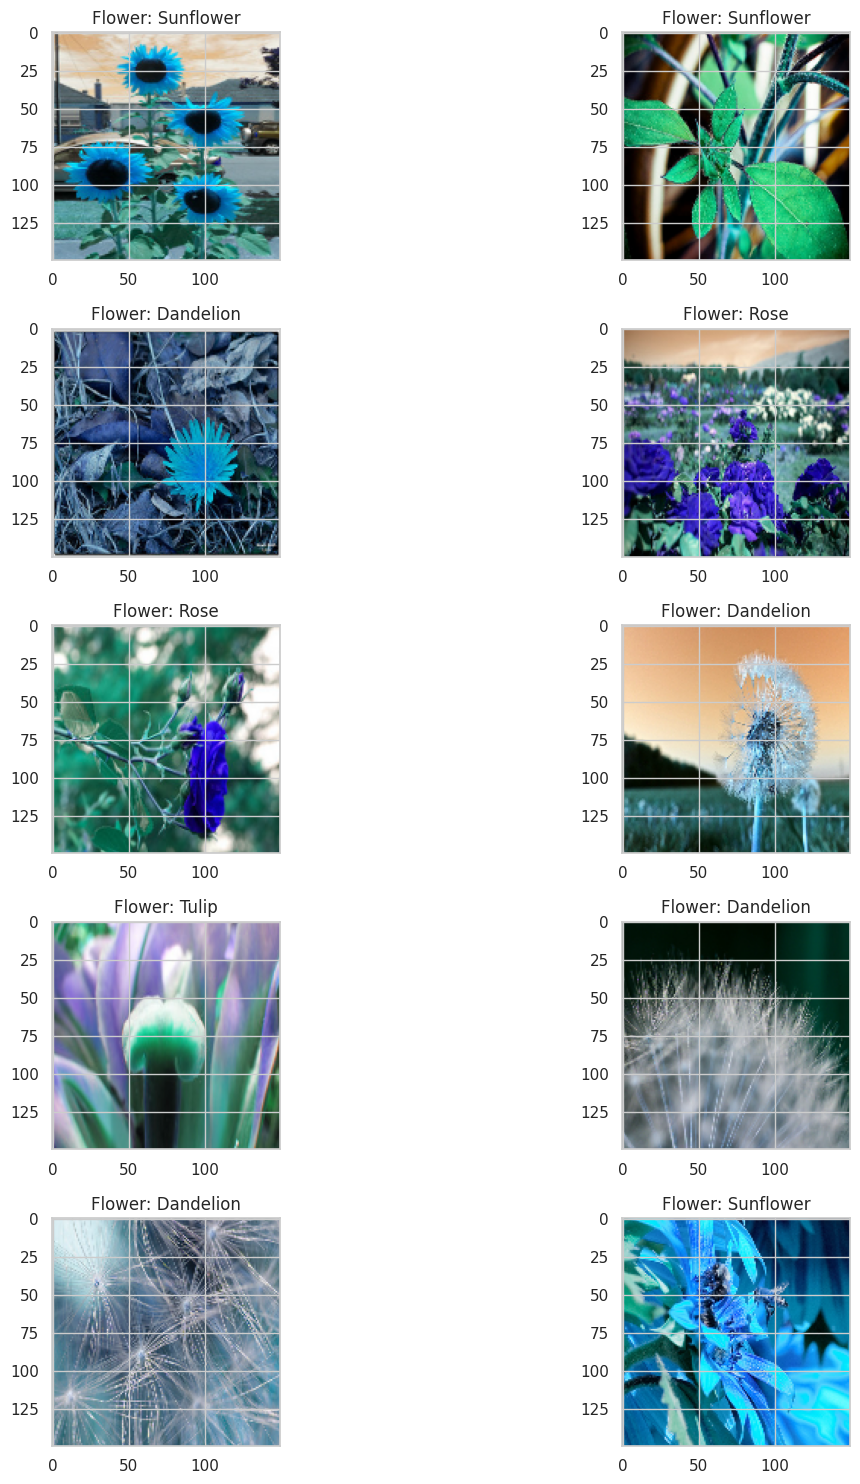

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()

For Label Encoding Such as Daisy -> 0

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

25 percent data for testing

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

Setting up random seeds

In [ ]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

Model Architecture

In [ ]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

Learning Rate and Model Summary

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,981,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,143,749 (15.81 MB)

 Trainable params: 4,143,749 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

Model Fit

In [ ]:
History = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (x_test,y_test),
                    verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                     callbacks=[red_lr])
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 981ms/step - accuracy: 0.2860 - loss: 1.5833 - val_accuracy: 0.4333 - val_loss: 1.2137 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4297 - loss: 1.3100 - val_accuracy: 0.4426 - val_loss: 1.2181 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 570ms/step - accuracy: 0.4744 - loss: 1.2112 - val_accuracy: 0.5352 - val_loss: 1.0572 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5405 - loss: 1.0240 - val_accuracy: 0.5676 - val_loss: 1.0338 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - accuracy: 0.5644 - loss: 1.0946 - val_accuracy: 0.6009 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6719 - loss: 0.9474 - val_accuracy: 0.5926 - val_loss: 0.9994 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 571ms/step - accuracy: 0.6045 - loss: 0.9995 -

Evaluating Performance

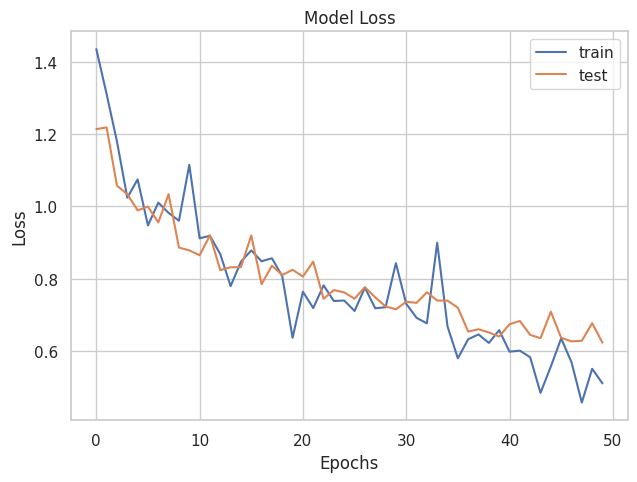

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

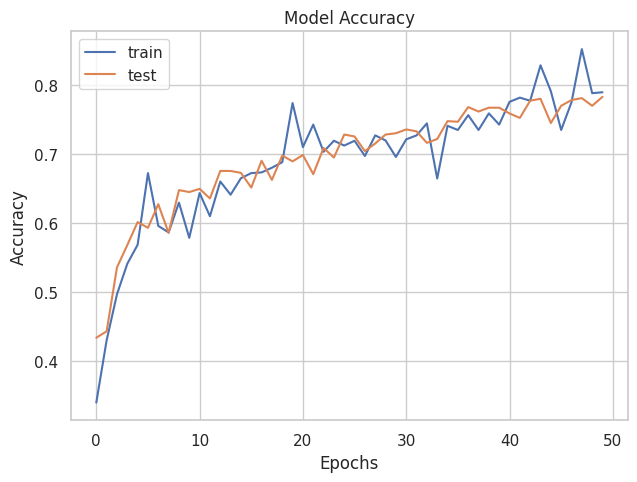

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Visualizing Predictons on the Validation Set

In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

CORRECTLY CLASSIFIED IMAGES OF FLOWERS

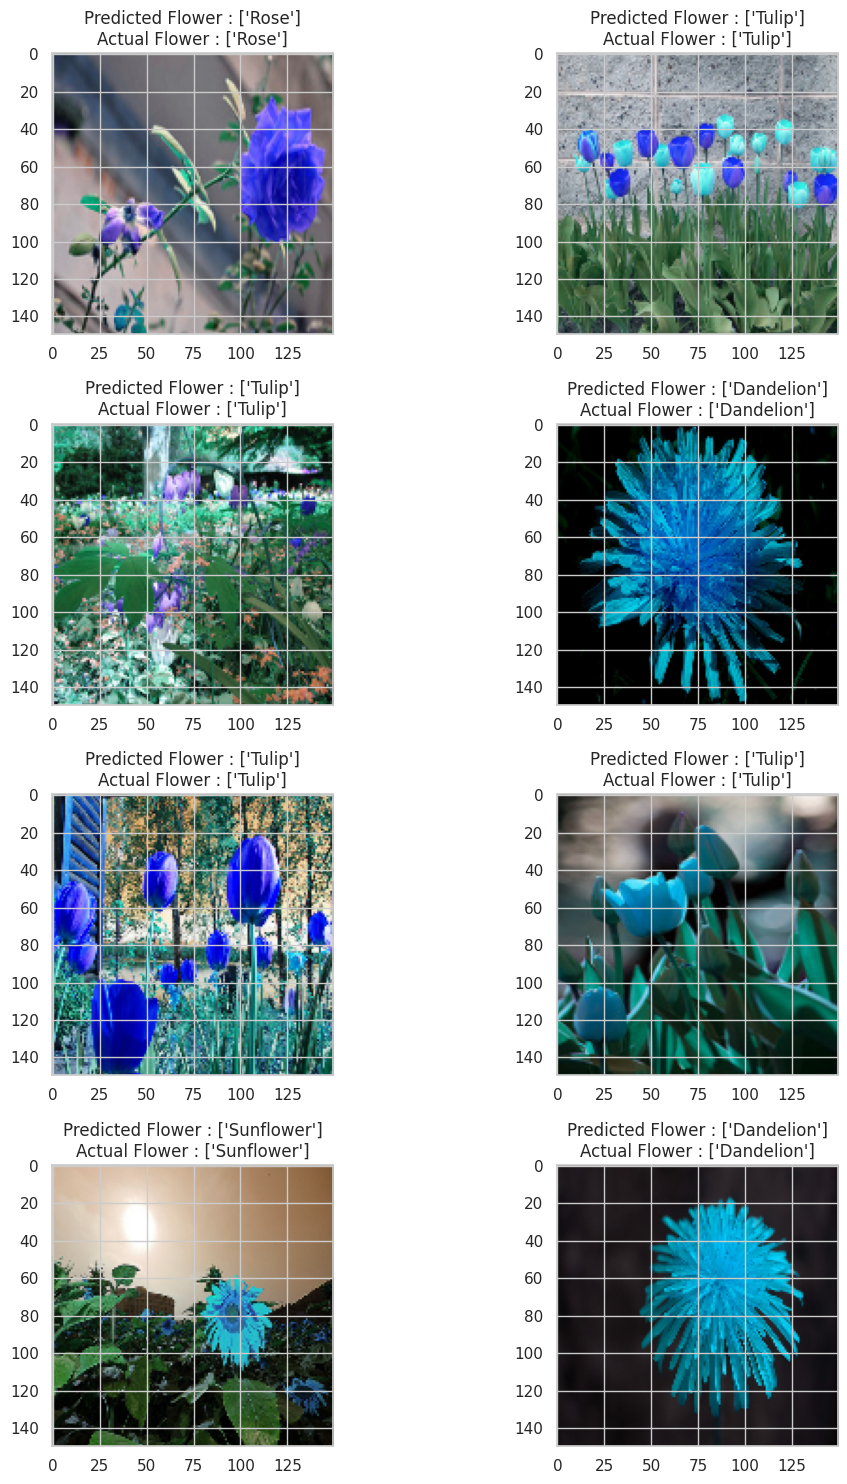

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        # Ensure the input to argmax is not empty and handle the potential empty array
        actual_flower_index = np.argmax(y_test[prop_class[count]]) if y_test[prop_class[count]].size else None
        actual_flower = le.inverse_transform([actual_flower_index]) if actual_flower_index is not None else ['Unknown']
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(actual_flower))
        plt.tight_layout()
        count+=1

MISCLASSIFIED IMAGES OF FLOWERS

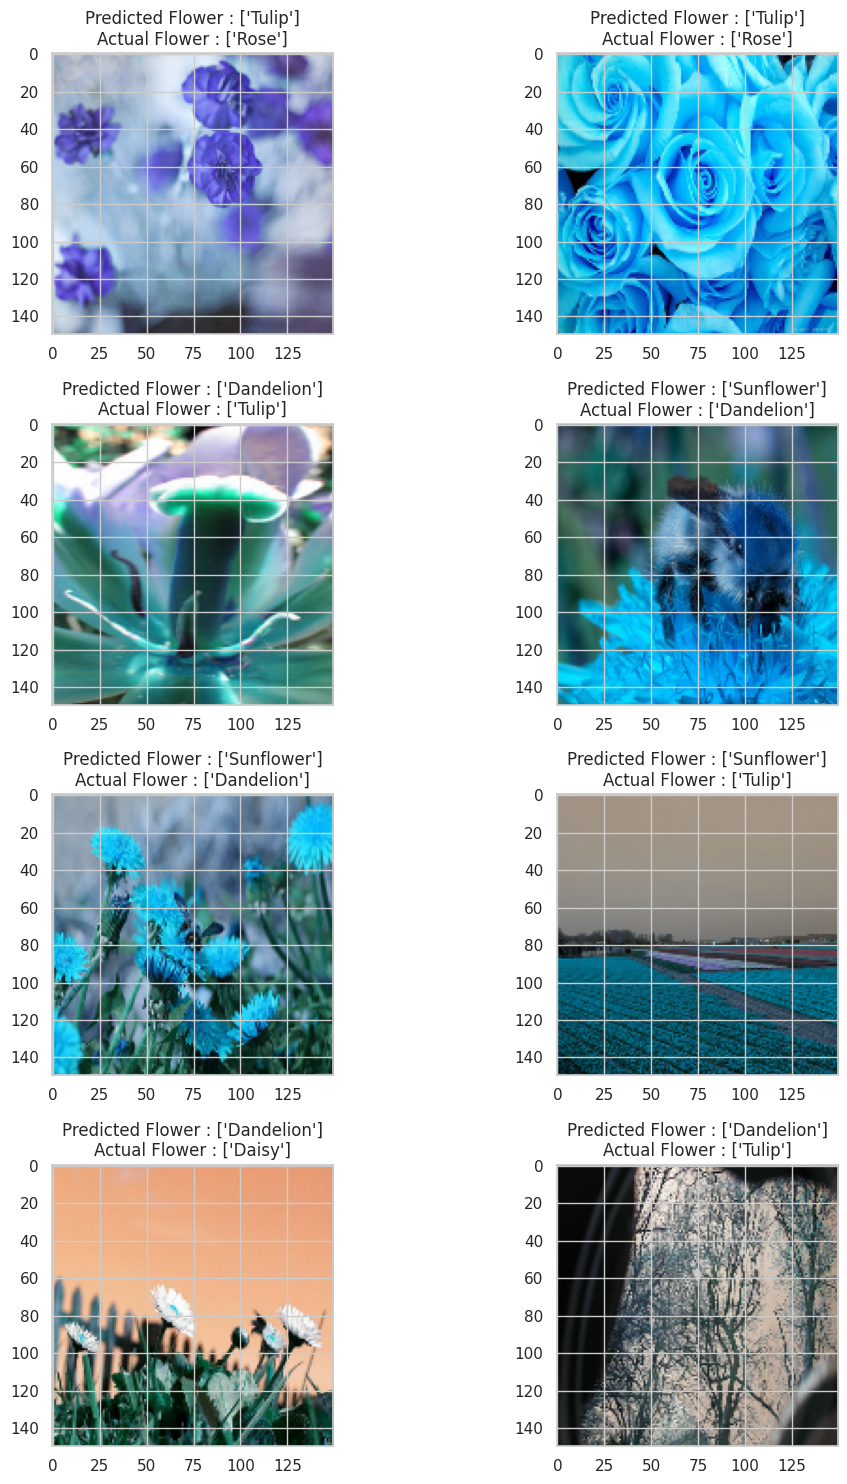

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        # Ensure the input to argmax is not empty and handle the potential empty array
        actual_flower_index = np.argmax(y_test[mis_class[count]]) if y_test[mis_class[count]].size else None
        actual_flower = le.inverse_transform([actual_flower_index]) if actual_flower_index is not None else ['Unknown']
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(actual_flower)) # Use the handled actual_flower variable
        plt.tight_layout()
        count+=1

Confusion Matrix

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


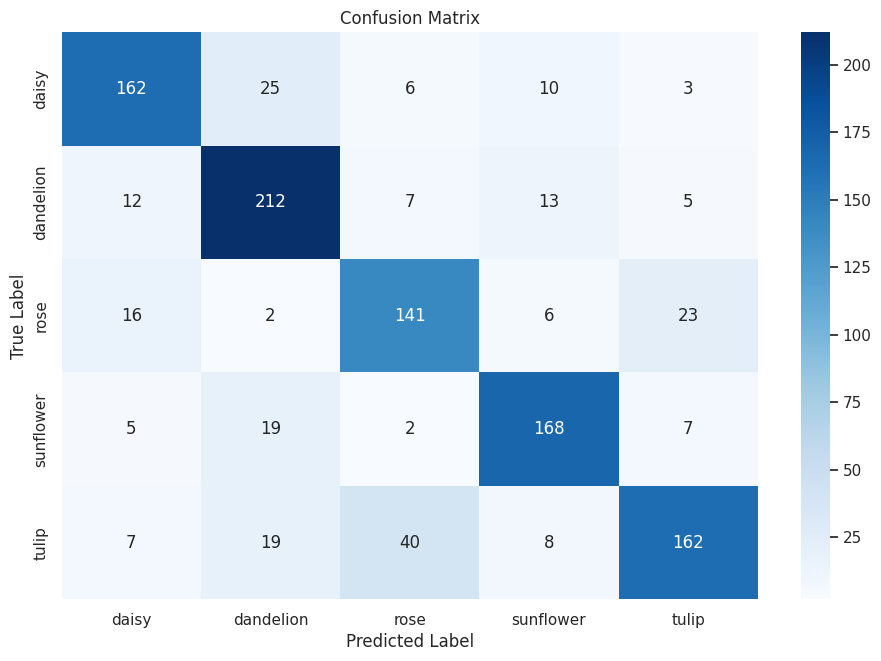

In [ ]:
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,7))
# Now you can use class_names
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
Accuracy

In [ ]:
train_accuracy = History.history['accuracy']
val_accuracy = History.history['val_accuracy']

print(f'Training Accuracy (last epoch): {train_accuracy[-1]:.2f}')
print(f'Validation Accuracy (last epoch): {val_accuracy[-1]:.2f}')

Training Accuracy (last epoch): 0.79
Validation Accuracy (last epoch): 0.78


In [ ]:
test_loss, test_accuracy = model.evaluate(datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False))

print(f'Test Loss: {test_loss:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 674ms/step - accuracy: 0.7602 - loss: 0.6884
Test Loss: 0.68
Test Accuracy: 0.77
